In [3]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
df_test = pd.read_csv("./2018-E-c-En-train.csv", sep=';')

not_chosen_columns = ['ID', 'Tweet']
label_columns = [col for col in df_test.columns if col not in not_chosen_columns]

df_labels_test = df_test[label_columns]

list_labels_test = df_labels_test.values.tolist()

test_texts = df_test['Tweet'].tolist()
test_labels = list_labels_test

tokenizer = BertTokenizer.from_pretrained("saved_model_try_8")
model = BertForSequenceClassification.from_pretrained("saved_model_try_8")

In [5]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_probabilities = []

# Process each text
for text in test_texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
    probabilities = probabilities.squeeze(0)

    all_probabilities.append(probabilities) #Değiştir

In [6]:
all_probabilities_l = []

for item in all_probabilities:
    all_probabilities_l.append(item.tolist())

In [7]:
#youden and f1
all_probabilities_pd = pd.DataFrame(all_probabilities_l)
test_labels_pd = pd.DataFrame(test_labels)

found_thres = []

for i in range( all_probabilities_pd.shape[1] ):
    
    best_thres = -1.0
    #best_youden = -1.0
    best_f1 = -1.0
    test_thresholds = np.arange(0.0, 1.0, 0.01).tolist()

    for i_thres in test_thresholds:
        col_prob = all_probabilities_pd.iloc[:,i]
        col_prob= torch.tensor(col_prob)

        col_true = test_labels_pd.iloc[:,i]
        col_true= torch.tensor(col_true)

        col_pred = (col_prob > i_thres).long()

        cm = confusion_matrix(col_true, col_pred)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]

        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

        youden_idx = sensitivity + specificity - 1
        f1 = f1_score(col_true, col_pred)

        #if( youden_idx > best_youden ):
        if( youden_idx > best_f1 ):
            #best_youden = youden_idx
            best_f1 = f1
            best_thres = i_thres
    
    found_thres.append(round(best_thres, 2))

print(found_thres)

all_probabilities_pd

[0.4, 0.74, 0.2, 0.95, 0.33, 0.87, 0.89, 0.82, 0.89, 0.95, 0.79]


,0,1,2,3,4,5,6,7,8,9,10
0,0.073986,0.414355,0.080309,0.228322,0.684769,0.271918,0.849135,0.121038,0.146865,0.043854,0.659979
1,0.073111,0.149679,0.070483,0.098568,0.885348,0.664346,0.855222,0.052604,0.090223,0.050223,0.309410
2,0.280425,0.524765,0.301754,0.076413,0.560221,0.082427,0.290300,0.079655,0.159274,0.627263,0.114658
3,0.064829,0.416759,0.068180,0.086846,0.824086,0.354683,0.835087,0.079290,0.100122,0.074632,0.658542
4,0.873991,0.079368,0.840583,0.254920,0.054418,0.021113,0.067543,0.136951,0.349097,0.042000,0.020308
...,...,...,...,...,...,...,...,...,...,...,...
6833,0.162034,0.441687,0.169074,0.174545,0.379625,0.057442,0.555984,0.089958,0.133016,0.044998,0.218573
6834,0.491784,0.455993,0.464102,0.053845,0.241200,0.029830,0.168298,0.099773,0.204749,0.273168,0.065596
6835,0.896038,0.140814,0.796148,0.077119,0.100395,0.024580,0.140280,0.093642,0.226683,0.045323,0.040005
6836,0.332225,0.577354,0.412882,0.171519,0.481909,0.113246,0.170563,0.165631,0.273455,0.811189,0.095250


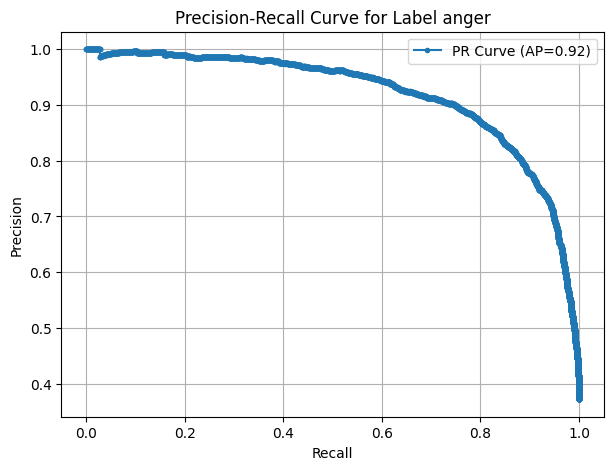

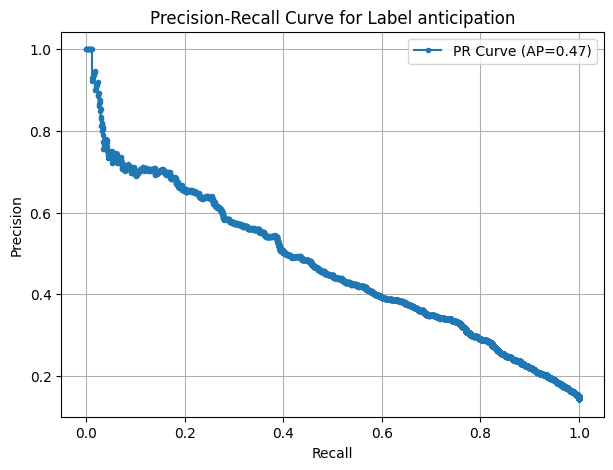

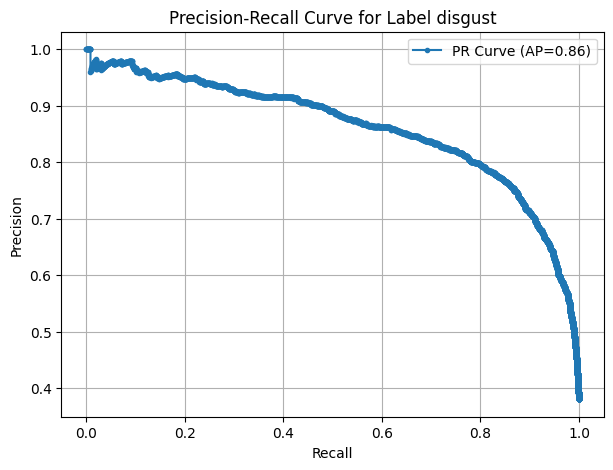

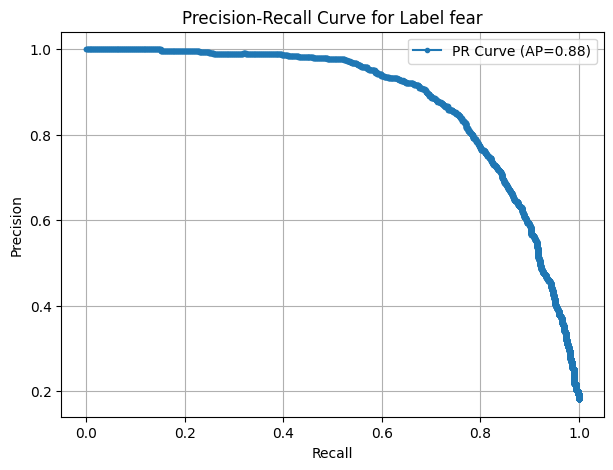

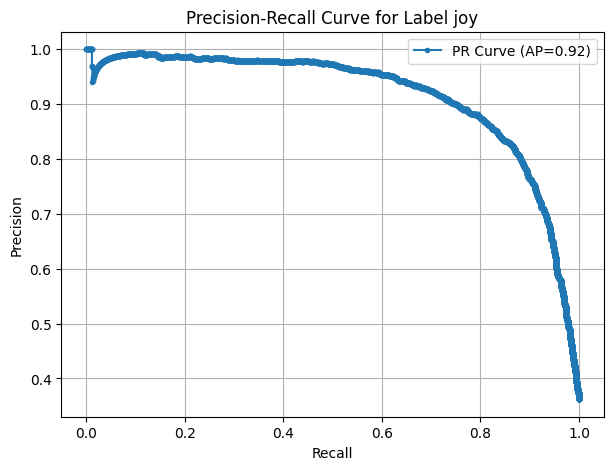

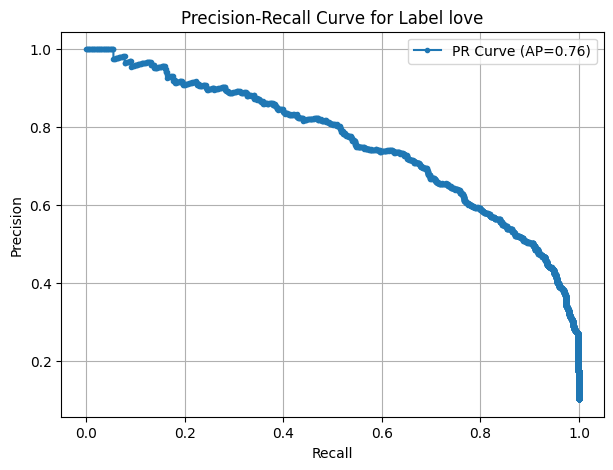

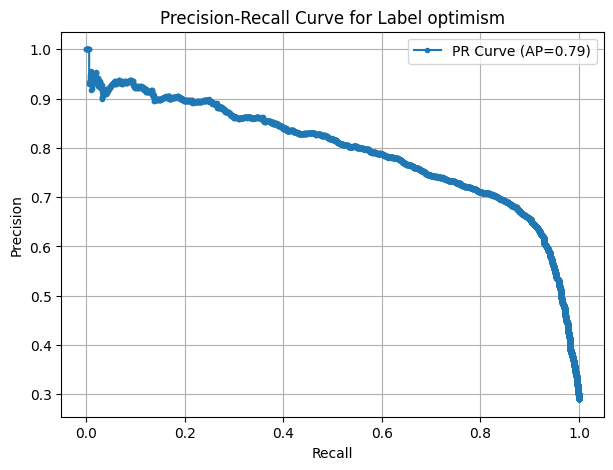

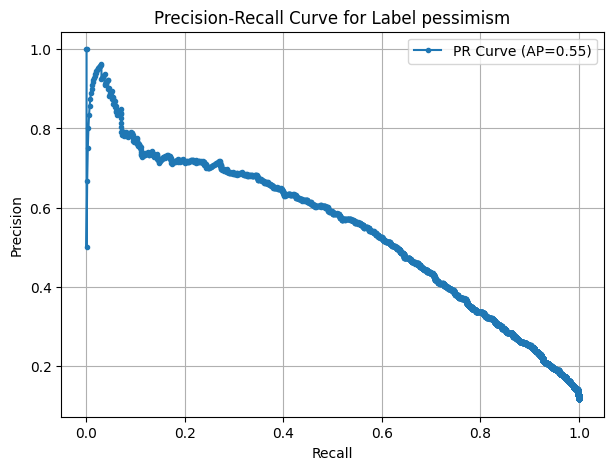

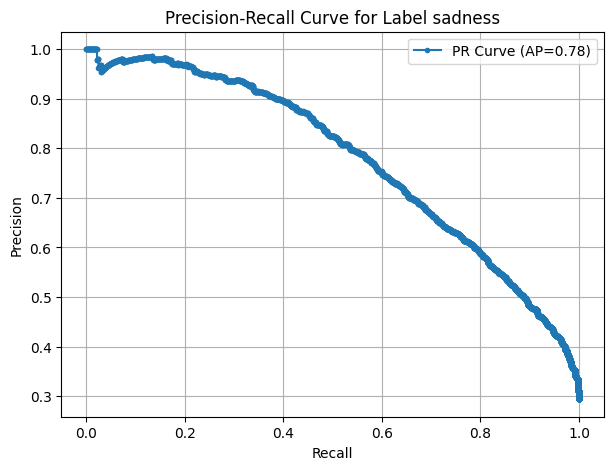

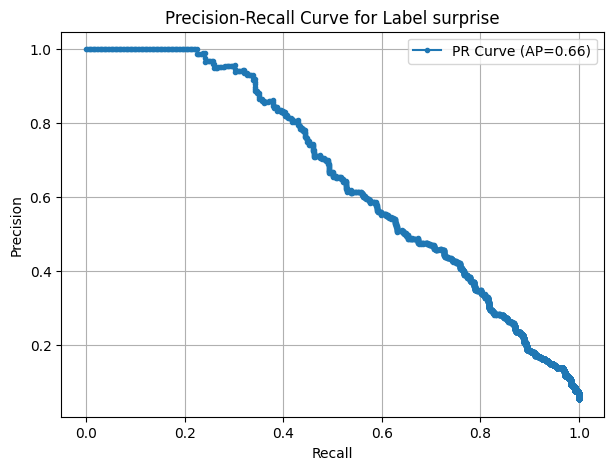

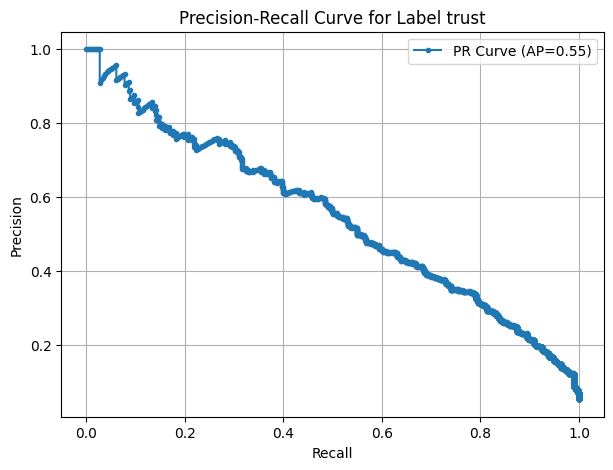

[0.5, 0.32, 0.44, 0.43, 0.37, 0.53, 0.33, 0.44, 0.37, 0.32, 0.44]


,0,1,2,3,4,5,6,7,8,9,10
0,0.073986,0.414355,0.080309,0.228322,0.684769,0.271918,0.849135,0.121038,0.146865,0.043854,0.659979
1,0.073111,0.149679,0.070483,0.098568,0.885348,0.664346,0.855222,0.052604,0.090223,0.050223,0.309410
2,0.280425,0.524765,0.301754,0.076413,0.560221,0.082427,0.290300,0.079655,0.159274,0.627263,0.114658
3,0.064829,0.416759,0.068180,0.086846,0.824086,0.354683,0.835087,0.079290,0.100122,0.074632,0.658542
4,0.873991,0.079368,0.840583,0.254920,0.054418,0.021113,0.067543,0.136951,0.349097,0.042000,0.020308
...,...,...,...,...,...,...,...,...,...,...,...
6833,0.162034,0.441687,0.169074,0.174545,0.379625,0.057442,0.555984,0.089958,0.133016,0.044998,0.218573
6834,0.491784,0.455993,0.464102,0.053845,0.241200,0.029830,0.168298,0.099773,0.204749,0.273168,0.065596
6835,0.896038,0.140814,0.796148,0.077119,0.100395,0.024580,0.140280,0.093642,0.226683,0.045323,0.040005
6836,0.332225,0.577354,0.412882,0.171519,0.481909,0.113246,0.170563,0.165631,0.273455,0.811189,0.095250


In [8]:
#Precision-Recall curve 

from sklearn.metrics import precision_recall_curve, average_precision_score

def optimize_threshold_pr(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]

    return best_threshold

all_probabilities_pd = pd.DataFrame(all_probabilities_l)
test_labels_pd = pd.DataFrame(test_labels)

found_thres = []

for i in range( all_probabilities_pd.shape[1] ):

    col_prob = all_probabilities_pd.iloc[:,i]
    col_prob= torch.tensor(col_prob)

    col_true = test_labels_pd.iloc[:,i]
    col_true= torch.tensor(col_true)

    best_thresh = optimize_threshold_pr(col_true, col_prob)

    precisions, recalls, thresholds = precision_recall_curve(col_true, col_prob)
    ap_score = average_precision_score(col_true, col_prob)

    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

    plt.figure(figsize=(7, 5))
    plt.plot(recalls, precisions, marker=".", label=f"PR Curve (AP={ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for Label {emotions[i]}")
    plt.legend()
    plt.grid()
    plt.show()
    
    found_thres.append(round(best_thresh, 2))

print(found_thres)

all_probabilities_pd